# Run a Watershed

This Notebook covers running a calibrated NEWT model for a selected watershed.

In [20]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
from NEWT import Watershed, perf_summary

In [54]:
ws = "10343500"
raw = pd.read_csv(r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi\USGS-" + f"{ws}.csv")
raw["date"] = pd.to_datetime(raw["datetime"]).dt.date
raw = raw.set_index(["date", "variable"])["mean"].unstack(1)[["tmax", "vp", "prcp"]]
raw

variable,tmax,vp,prcp
date,,,
2000-01-01,1.196154,288.28152,5.166539
2000-01-02,-0.663077,208.34999,0.000000
2000-01-03,6.506923,339.36383,0.000000
2000-01-04,1.881923,347.22806,0.000000
2000-01-05,1.855000,272.50308,0.000000
...,...,...,...
2022-12-27,3.190384,492.26614,39.528847
2022-12-28,1.175385,377.98580,0.000000
2022-12-29,2.854615,437.02386,9.133078


In [33]:
stdat = nwis.get_dv(sites=[ws], start="2000-01-01", end="2022-12-31", parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna()
stdat

,temperature
date,
2016-10-01,7.1
2016-10-02,5.2
2016-10-03,5.0
2016-10-04,5.1
2016-10-05,4.4
...,...
2022-12-27,1.4
2022-12-28,1.5
2022-12-29,2.3


In [59]:
data = stdat.merge(raw, on="date")
data["date"] = pd.to_datetime(data.index).normalize()
data.index = range(len(data))
data

,temperature,tmax,vp,prcp,date
0,7.1,14.275771,220.44577,0.000000,2016-10-01
1,5.2,8.242693,237.84767,5.740000,2016-10-02
2,5.0,4.947692,246.82191,1.946538,2016-10-03
3,5.1,9.919999,183.59769,0.000000,2016-10-04
4,4.4,10.171153,168.00691,0.000000,2016-10-05
...,...,...,...,...,...
2208,1.4,3.190384,492.26614,39.528847,2022-12-27
2209,1.5,1.175385,377.98580,0.000000,2022-12-28
2210,2.3,2.854615,437.02386,9.133078,2022-12-29
2211,1.7,4.925000,633.59540,74.243460,2022-12-30


In [70]:
cut = round(len(data) * 0.7)
cal = data.iloc[:cut,:]
val = data.iloc[cut:,:]
print(f"Cal: {min(cal['date'].dt.date)} - {max(cal['date'].dt.date)} | Val: {min(val['date'].dt.date)} - {max(val['date'].dt.date)}")

Cal: 2016-10-01 - 2021-03-07 | Val: 2021-03-08 - 2022-12-31


In [61]:
model = Watershed.from_data(cal)

C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\watershed.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data["date"].dt.day_of_year
C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\newt\src\NEWT\watershed.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data["date"].dt.day_of_year


In [62]:
pred = model.run_series(val)

In [64]:
perf_summary(pred)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.926077,1.469682,0.884191,-13.299349,-0.879279,2.284744


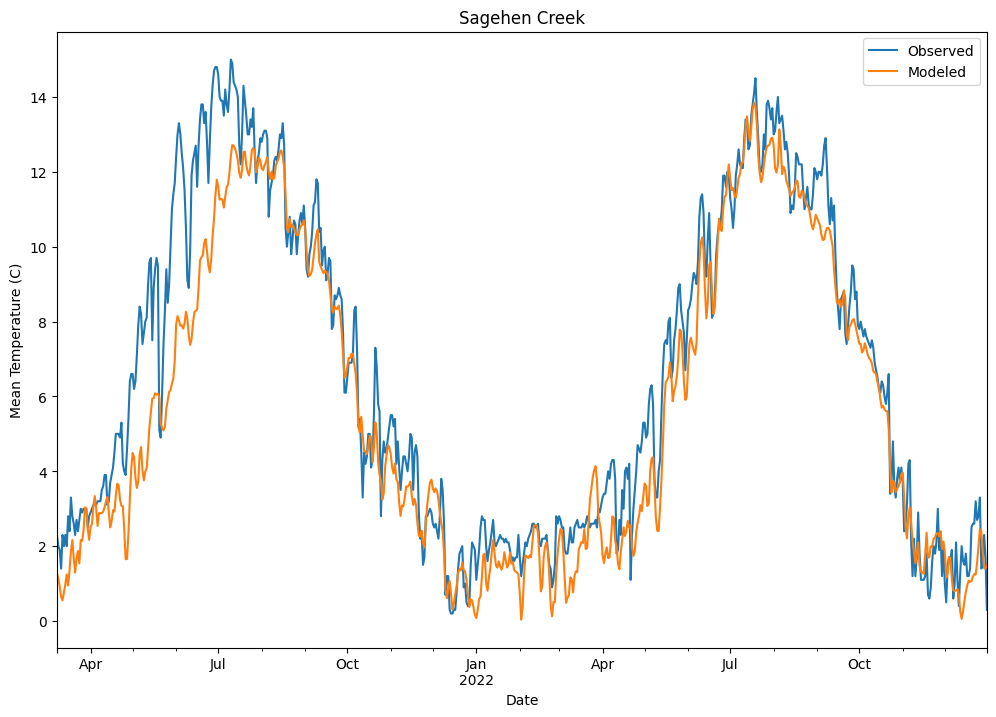

In [83]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
pred.plot(x="date", y="temperature", label="Observed", ax=ax)
pred.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Sagehen Creek")
fig.savefig("SagehenCalibrated.png")